<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/Majority_Voting/mv_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Subclassing for MV

In [ ]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_PRI(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=70,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.2, verbose=1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K

    
 
 
 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate,clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate,clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*4*(self.K+self.R)),activation='selu',name='h1',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics="accuracy")
         
            
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K
                }

  
        return self


# Load Data

In [ ]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2023-02-03 16:29:39--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 74.125.197.139, 74.125.197.138, 74.125.197.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ko3eocs71kmr8ke0t33ideuc0mc57hdl/1675441725000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=4b0046a3-2e4b-4b49-8c5a-e2393d537403 [following]
--2023-02-03 16:29:39--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ko3eocs71kmr8ke0t33ideuc0mc57hdl/1675441725000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=4b0046a3-2e4b-4b49-8c5a-e2393d537403
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 74.125.142.132, 

In [ ]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Segmentation' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


path_ = 'MADatasets/'+ database+ '.mat' 
Xdata = sio.loadmat(path_)
Xdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Y', 'iAnn', 'Exp', 'idxtr', 'idxte'])

In [ ]:


X = Xdata['X']
# Xte = Xdata['Xte']
Y = Xdata['Y']
t = Xdata['y'].reshape(-1)
print('X',X.shape,'t',t.shape,'Y',Y.shape)
 

X (2310, 18) t (2310,) Y (2310, 5)


In [ ]:
t

array([1, 1, 1, ..., 7, 7, 7], dtype=uint8)

# Labels Generation - 1 Cluster, 3 annotators

In [ ]:
import random
import warnings
import numpy as np
#import climin
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Defining the Sigmoid function and Softmax function
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

def MAjVot(Y, K):
    N,R = Y.shape
    Yhat = np.zeros((N,1))
    for n in range(N):
        votes = np.zeros((K,1))
        for r in range(R):
            for k in range(K):
                if Y[n,r] == k+1:
                    votes[k] = votes[k]+1
        Yhat[n] = np.argmax(votes) + 1
    return Yhat


def  MA_Clas_Gen(Xtrain,ytrain,R,NrP):

    N = len(ytrain)
    K = len(np.unique(ytrain))
    Kn = np.unique(ytrain)
    aux = 0
    A = np.zeros((K,1))
    for k in Kn:
        A[aux] = (ytrain == k).sum()
        aux = aux + 1
    per = np.min(A)
    if N < 25000:
        Xtrain = TSNE(n_components=1,perplexity=per/2).fit_transform(Xtrain)
    else:
        Xtrain = np.sum(Xtrain,1)
     
    Xtrain = Xtrain - Xtrain.min()
    #print(Xtrain.min(), Xtrain.max())
    Xtrain = Xtrain/Xtrain.max()
    Xtrain = Xtrain.reshape((N,1))
    yprueba = np.ones((N,1))
    
    
    u_q = np.empty((Xtrain.shape[0],3))
    u_q[:,0,None] = 4.5*np.cos(2*np.pi*Xtrain + 1.5*np.pi) - \
                               3*np.sin(4.3*np.pi*Xtrain + 0.3*np.pi)
                    
    u_q[:,1,None] = 4.5*np.cos(1.5*np.pi*Xtrain + 0.5*np.pi) + \
                       5*np.sin(3*np.pi*Xtrain + 1.5*np.pi)
    
    u_q[:,2,None] = 1
    
    W = []
    # q=1
    Wq1 = np.array(([[0.4],[0.7],[-0.5],[0],[-0.7]]))
    W.append(Wq1)
    # q=2
    Wq2 = np.array(([[0.4],[-1.0],[-0.1],[-0.8],[1.0]]))
    W.append(Wq2)
    Wq3 = np.array(([[3.1],[-1.8],[-0.6],[-1.2],[1.0]]))
    W.append(Wq3)

    
    F_r = []
    Lam_r = []
    for r in range(R):
        f_r = np.zeros((Xtrain.shape[0], 1))
        # rho_r = np.zeros((Xtrain.shape[0], 1))
        for q in range(3):
            f_r += W[q][r].T*u_q[:,q,None]
        F_r.append(f_r)
        lam_r = Sigmoid(f_r)
        lam_r[lam_r>0.5] = 1
        lam_r[lam_r<=0.5] = 0
        Lam_r.append(lam_r)
    plt.plot(Xtrain,Lam_r[2],'rx')
    plt.show()
    seed = 0
    np.random.seed(seed)
    Ytrain = np.ones((N, R))
    for r in range(R):
        aux = ytrain.copy()
        for n in range(N):
            if Lam_r[r][n] == 0:
                labels = np.arange(1, K+1)
                a = np.where(labels==ytrain[n])
                labels = np.delete(labels, a)
                idxlabels = np.random.permutation(K-1)
                aux[n] = labels[idxlabels[0]]         
        Ytrain[:,r] = aux.flatten()
        
   # Ytrain = (Ytrain*maxy) + miny
        
    iAnn = np.zeros((N, R), dtype=int) # this indicates if the annotator r labels the nth sample.
    Nr = np.ones((R), dtype=int)*int(np.floor(N*NrP))  
    for r in range(R):
        if r < R-1:
            indexR = np.random.permutation(range(N))[:Nr[r]]
            iAnn[indexR,r] = 1
        else:
            iSimm = np.sum(iAnn, axis=1)
            idxZero = np.asarray([i for (i, val) in enumerate(iSimm) if val == 0])
            Nzeros = idxZero.shape[0]
            idx2Choose = np.arange(N)
            if Nzeros == 0:
                indexR = np.random.permutation(range(N))[:Nr[r]]
                iAnn[indexR,r] = 1
            else:
                idx2Choose = np.delete(idx2Choose, idxZero)
                N2chose = idx2Choose.shape[0]
                idxNoZero = np.random.permutation(N2chose)[:(Nr[r] - Nzeros)]
                idxTot = np.concatenate((idxZero, idx2Choose[idxNoZero]))
                iAnn[idxTot,r] = 1
    
    # Now, we verify that all the samples were labeled at least once
    Nr = (np.sum(iAnn,0))
    iSimm = np.sum(iAnn, axis=1)
    if np.asarray([i for (i, val) in enumerate(iSimm) if val == 0]).sum() == 0:
        ValueError("all the samples must be labeled at least once")

    # Finally, if iAnn=0 we assign a reference value to indicate a missing value
    Vref = -1e-20
    for r in range(R):
        Ytrain[iAnn[:,r] == 0, r] = Vref 

    return Ytrain, iAnn, Lam_r


def CrossVal(X, pp, Nk):
    N = X.shape[0]
    Ntr = int(N*pp)
    Nte = N - Ntr
    idxtr = np.zeros((Ntr,Nk))
    idxte = np.zeros((Nte,Nk))
    
    for i in range(Nk):
        index = np.random.permutation(range(N))
        idxtr[:,i] = index[:Ntr]
        idxte[:,i] = index[Ntr:]
        
    return idxtr, idxte
    
    
        


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


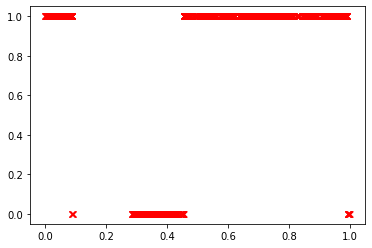

In [ ]:
Y, iAnn, Lam_r = MA_Clas_Gen(X ,t, R=5, NrP=1)

In [ ]:

Y = Y - 1
t = t - 1
 

In [ ]:
import numpy as np
from scipy import stats
Ytr_mv  = []
for i in range(Y.shape[0]):
     #print(Y[i])
     Ytr_mv   += [np.take(stats.mode(Y[i]),0)]
     #print(mode_Y)
#Ytr_mv 

In [ ]:
Ytr_mv = np.array(Ytr_mv).reshape(-1,1) 
Ytr_mv.shape

(2310, 1)

In [ ]:
from sklearn.metrics import classification_report

for i in range(Ytr_mv.shape[1]):
  print('annotator',i+1)
  print(classification_report(t,Ytr_mv))


annotator 1
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       330
           1       0.90      1.00      0.95       330
           2       0.91      0.83      0.87       330
           3       0.94      0.90      0.92       330
           4       0.95      0.92      0.94       330
           5       0.96      1.00      0.98       330
           6       0.95      0.90      0.93       330

    accuracy                           0.93      2310
   macro avg       0.93      0.93      0.93      2310
weighted avg       0.93      0.93      0.93      2310



# Split data

In [ ]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3, random_state=123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:], Ytr_mv[train_index,:], Ytr_mv[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[2031  671 1207 1236  343 1158  822  558   18 1644 2044 2257 1440 1290
 1758 2263 1422 1633   33  689  206 1380 2291   25 1652  961  279 2076
 1777  995 1424  493  132  224 1278 1162 1121 1496 2303  327 1233 1631
  417 1036  977 1708 2248 1204  803  711  856   50 2249  511 1567 1068
 1725   12 2097  704 1667 1253 2041  965 1055 1237 2071 2165 1106 1873
 2153  141 1860 1033  266 1661 1730  978 1614  813 1148   45 2045 2030
 1181 1209  746  421 2197 1331 2034  875 1049 1404 1137 1851  683  809
  515 1195 1256 2102 1018  967  476 1337 2170 1982  615 2177  388 1548
 1744  110  835 2100 1126 1109  935 1802 1977 1797  668  820  190 1707
 1542 1541  289  784 1446 1979 1903  326  292  420  798  239 1831  310
  449  708 1201 2176 1449   72  982  800 2213  403  381  148 1531  601
  466 2152 1676  351 1269 1412  728 1143  116 1790 1843 1818  658 1525
 2308 1333  735 1059  777 1637 2243 1686  409 1697 1978 1516 1217 2304
 1757  701 2266  120  680 1728  906  988  670 2179  375 1373 1913 1182
   58 

# Apply MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


iteration: 0


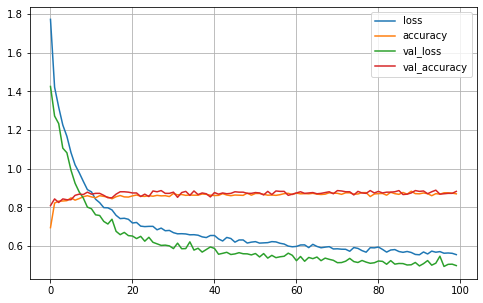

22/22 [==============================] - 0s 2ms/step
Validation ACC: 0.9293
Validation Balanced_ACC: 0.9189
Validation MI: 1.7044
Validation Normalized MI: 0.8765
Validation Adjusted MI: 0.8748
Validation aUc: 0.9907
iteration: 1


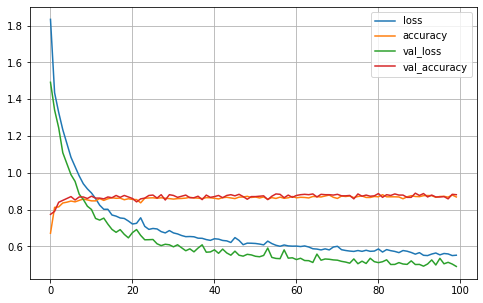

22/22 [==============================] - 0s 2ms/step
Validation ACC: 0.9177
Validation Balanced_ACC: 0.9054
Validation MI: 1.6605
Validation Normalized MI: 0.8540
Validation Adjusted MI: 0.8519
Validation aUc: 0.9925
iteration: 2


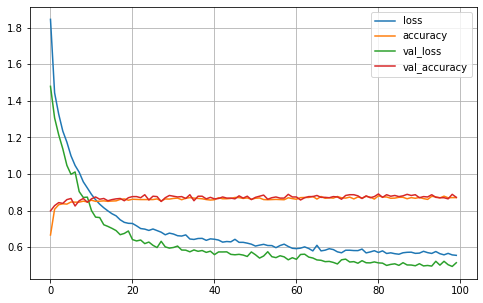

22/22 [==============================] - 0s 2ms/step
Validation ACC: 0.9019
Validation Balanced_ACC: 0.8874
Validation MI: 1.6195
Validation Normalized MI: 0.8346
Validation Adjusted MI: 0.8323
Validation aUc: 0.9916
iteration: 3


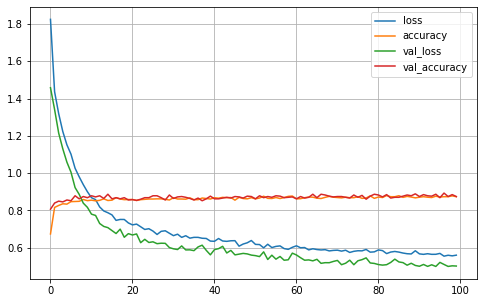

22/22 [==============================] - 0s 3ms/step
Validation ACC: 0.9062
Validation Balanced_ACC: 0.8923
Validation MI: 1.6181
Validation Normalized MI: 0.8328
Validation Adjusted MI: 0.8305
Validation aUc: 0.9824
iteration: 4


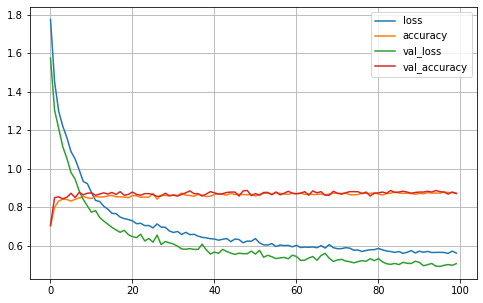

22/22 [==============================] - 0s 2ms/step
Validation ACC: 0.9033
Validation Balanced_ACC: 0.8891
Validation MI: 1.6243
Validation Normalized MI: 0.8360
Validation Adjusted MI: 0.8337
Validation aUc: 0.9899
iteration: 5


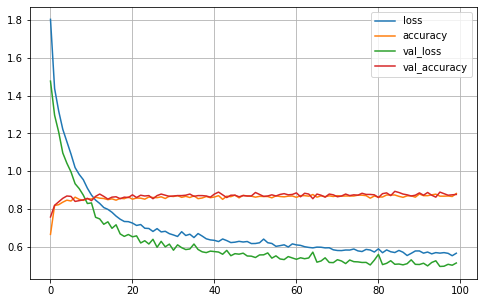

22/22 [==============================] - 0s 2ms/step
Validation ACC: 0.9048
Validation Balanced_ACC: 0.8901
Validation MI: 1.6117
Validation Normalized MI: 0.8287
Validation Adjusted MI: 0.8264
Validation aUc: 0.9782
iteration: 6


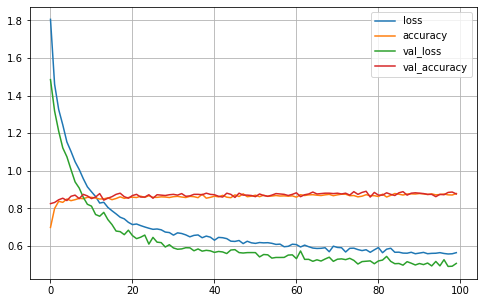

22/22 [==============================] - 0s 3ms/step
Validation ACC: 0.9105
Validation Balanced_ACC: 0.8977
Validation MI: 1.6138
Validation Normalized MI: 0.8301
Validation Adjusted MI: 0.8278
Validation aUc: 0.9891
iteration: 7


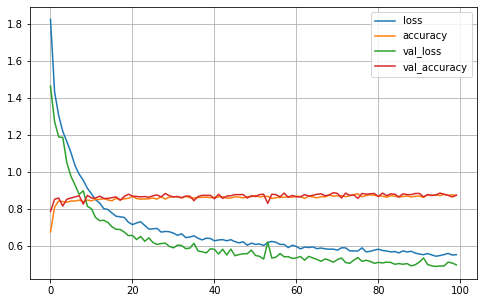

22/22 [==============================] - 0s 3ms/step
Validation ACC: 0.9048
Validation Balanced_ACC: 0.8907
Validation MI: 1.6224
Validation Normalized MI: 0.8351
Validation Adjusted MI: 0.8328
Validation aUc: 0.9824
iteration: 8


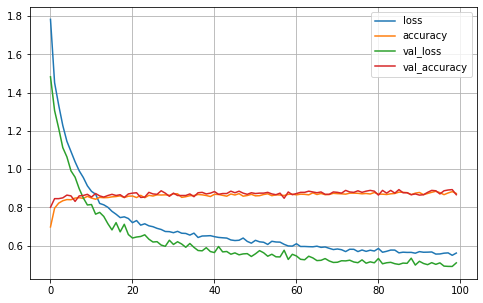

22/22 [==============================] - 0s 2ms/step
Validation ACC: 0.9264
Validation Balanced_ACC: 0.9159
Validation MI: 1.6953
Validation Normalized MI: 0.8720
Validation Adjusted MI: 0.8703
Validation aUc: 0.9849
iteration: 9


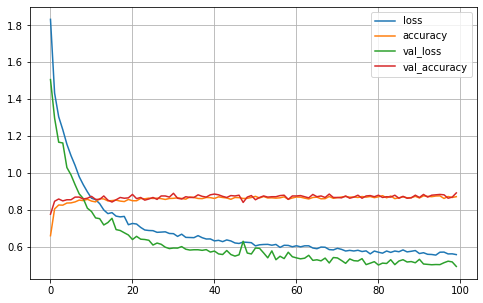

22/22 [==============================] - 0s 2ms/step
Validation ACC: 0.9062
Validation Balanced_ACC: 0.8915
Validation MI: 1.6417
Validation Normalized MI: 0.8462
Validation Adjusted MI: 0.8441
Validation aUc: 0.9891


In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =  0.0001
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_PRI(epochs=100,batch_size=32,R=5, K=len(np.unique(Y_true_train)), dropout=0.25, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.3, verbose=0)
    
    MA.fit(X_train, Y_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))


    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    

In [ ]:
 
# from sklearn.metrics import classification_report
# l1 =  0.0001
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))

#     MA = Keras_MA_PRI(epochs=100,batch_size=32,R=5, K=len(np.unique(Y_true_train)), dropout=0.25, learning_rate=0.001,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.3, verbose=0)
#     MA.fit(X_train, Y_train)
#     MA.plot_history()
  
#     #Accuracy
#     pred_2 = MA.predict(X_test)
 
#     report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
#     ACC[i] = report['accuracy']
#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)  
#     val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test, val_logits.argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
    
  

In [ ]:

ACC

array([0.92929293, 0.91774892, 0.9018759 , 0.90620491, 0.9033189 ,
       0.9047619 , 0.91053391, 0.9047619 , 0.92640693, 0.90620491])

In [ ]:

AUC

array([0.99072617, 0.99246228, 0.99162483, 0.9824121 , 0.98994976,
       0.97819829, 0.98911226, 0.9824121 , 0.98492467, 0.98911226])

In [ ]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  91.11
Average std:  0.9400000000000001
Average AUC:  98.71
Average AUC std:  0.44999999999999996
Average Balanced Accuracy:  89.79
Average std:  1.09
Average MI:  164.12
Average std:  3.25
Average Normalized MI:  84.46000000000001
Average std:  1.6500000000000001
Average Ajdusted MI:  84.25
Average std:  1.67
